# ДЗ по "Сбор и разметка данных (семинары)"
## Семинар 9. Инструменты разметки наборов данных
* Домашнее задание:
- Задача 1.
Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.

- Задача 2.
Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.

- Задача 3.
Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.

- Задача 4.
Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.

- Задача 5.
Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.

- Задача 6.
Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.



In [4]:
# Устанавливаем пакеты, если они не установлены
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn
# !pip install label-studio
# !pip install matplotlib
# !pip install wget

In [ ]:
import pandas as pd
import nltk
# Загружаем предобученную модель токенизации текста
nltk.download('punkt')
import csv
import os
import wget
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score

## Загрузка датасетов

###  Загрузка датасета новостей c lenta.ru

In [7]:
# Загрузим датасет с новостями с lenta.ru
news = pd.read_csv('news_lenta_ru.csv', engine='python', on_bad_lines='skip')

In [8]:
news

,url,title,text,topic,tags
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая
...,...,...,...,...,...
9995,https://lenta.ru/news/2000/07/10/kpp/,На границе Дагестана и Чечни будут стрелять в ...,Глава МВД Дагестана приказал нарядам милиции н...,Россия,Все
9996,https://lenta.ru/news/2000/07/10/gossovet/,Путин пересадит губернаторов в Госсовет,Представители Кремля ведут активный диалог с г...,Россия,Все
9997,https://lenta.ru/news/2000/07/10/clowns/,В Москву съедутся клоуны со всего мира,"В Москве 20 июля открывается фестиваль ""Планет...",Россия,Все
9998,https://lenta.ru/news/2000/07/10/women/,Старшая Уильямс выигрывает чемпионский титул,Чисто американским получился финал Уимблдонск...,Спорт,Все


### Загрузка тонального словаря

In [25]:
# Датасет тонального словаря
url = 'https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv'
path = 'kartaslovsent.csv'
if not os.path.isfile("kartaslovsent.csv"):
    # Загружаем данные
    wget.download(url, out=path)

In [26]:
df_tone_dictionary = pd.read_csv('kartaslovsent.csv', sep=';', on_bad_lines='skip')

In [27]:
df_tone_dictionary

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19
...,...,...,...,...,...,...,...,...
46122,ёмкость,NEUT,0.00,0.167,0.000,0.690,0.143,0.00
46123,ёрзать,NGTV,-0.54,0.050,0.446,0.397,0.107,0.00
46124,ёрничать,NGTV,-0.79,0.078,0.529,0.236,0.157,0.00
46125,ёрш,NEUT,0.16,0.224,0.072,0.576,0.128,0.00


## Присвоение метки настроения заголовкам новостей

### Перемешаем и разделим датафрейм на две части (1-разметка вручную, 2-разметка на основе правил)

In [28]:
# Перемешаем и разделим датафрем на 2 части
title_news_1, title_news_2 = train_test_split(news['title'], train_size=5, random_state=42)

In [29]:
# Преобразуем полученые датасеты в датафреймы Pandas
df_title_news_1 = pd.DataFrame(title_news_1)
df_title_news_2 = pd.DataFrame(title_news_2)

In [30]:
df_title_news_1.head()

,title
5734,Ястржембский называет имя арестованного за взр...
5191,"Чемпионат Италии: ""Ювентус"" ушел в отрыв"
5390,Из Чернокозово отпущены первые амнистированные...
860,Парламент Украины затребовал у Конгресса США п...
7270,Пилот Формулы-1 уцелел в авиакатастрофе


In [31]:
df_title_news_2.head()

,title
6252,"Чтобы не платить налог, интернет-изданиям нужн..."
4684,Кубинского дипломата выставили из США
1731,Правительство РФ: третье тысячеление наступит ...
4742,Взрывчатку в Сибирь отправили по почте
4521,В Дагестане совершено покушение на генерала по...


### Определение функций

In [32]:
# Функция для присвоения метки настроения на основе наличия положительных или отрицательных слов
def get_sentiment(text, df_td=df_tone_dictionary):
    '''
    Функция вычисляет метрику настроения.

    :param text: текст который будем анализировать,
    :param df_td: тональный словарь,
    :return: возвращает оценку тональности: -0.35 (неготив) <= нейтрально >= (0.55) позитив 
    '''
    # Токенизация текста на отдельные слова
    words = nltk.word_tokenize(text.lower())
    sum_value = 0  # Сумма всех зачений весов найденных слов
    
    for word in words:
        if len(df_td[df_td.term == word]):
            df_filtered = df_td[df_td['term'] == word]
            value = df_filtered['value'].iloc[0]
            sum_value += value
 
    return sum_value   


In [33]:
# Определение функции для присвоения метки настроения на основе оценки полярности настроения
def get_sentiment_label(score):
    '''
    Функция выводит метку настроения (негативный, позитивный или нейтральный).

    :param score: уровень метки настроения от -1 до 1,
    :return: возвращает оценку тональности. 
    '''
    if score < -0.35:
        return 'negative'  
    elif score >= 0.55:
        return 'positive' 
    else:
        return 'neutral'

#### Проверка функций

In [34]:
%%time
get_sentiment('Превосходно, что Аист прелетел')

CPU times: total: 15.6 ms
Wall time: 19.9 ms


0.55

In [35]:
get_sentiment('Удар молнии')

-0.68

In [36]:
get_sentiment('Всё в норме')

0

In [37]:
get_sentiment_label(get_sentiment('Превосходно, что Аист прелетел'))

'positive'

In [38]:
get_sentiment_label(get_sentiment('Удар молнии'))

'negative'

In [39]:
get_sentiment_label(get_sentiment('Всё в норме'))

'neutral'

### Присваиваем метки

#### Присвоение меток настроения на основе правил

In [40]:
%%time
# Применение функции к столбцу 'title' датасета для получения полярности настроения каждого заголовка новости
df_title_news_2['sentiment'] = df_title_news_2['title'].apply(get_sentiment)
# Применение функции к столбцу 'sentiment' датасета для присвоения меток настроения
df_title_news_2['sentiment_label'] = df_title_news_2['sentiment'].apply(get_sentiment_label)

CPU times: total: 4min 8s
Wall time: 4min 8s


In [41]:
df_title_news_2.head()

,title,sentiment,sentiment_label
6252,"Чтобы не платить налог, интернет-изданиям нужн...",-0.26,neutral
4684,Кубинского дипломата выставили из США,0.00,neutral
1731,Правительство РФ: третье тысячеление наступит ...,-0.14,neutral
4742,Взрывчатку в Сибирь отправили по почте,0.00,neutral
4521,В Дагестане совершено покушение на генерала по...,-1.00,negative


In [42]:
df_title_news_2.shape

(9995, 3)

#### Присвоение меток настроения в label-studio

##### Сохраним датафрем в CSV файл

In [46]:
df_title_news_1.to_csv('manual_marking.csv', index=False)

##### Запускаем локально label-studio

In [47]:
!label-studio

"label-studio" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


##### Экспортируем размеченный вручную CSV файл и зогружаем его в датафрейм

In [50]:
df_title_news_1 = pd.read_csv('project-1-at-2024-04-14-20-19-3822a918.csv', engine='python', on_bad_lines='skip')

In [51]:
df_title_news_1.head()

,annotation_id,annotator,created_at,id,lead_time,sentiment,title,updated_at
0,1,1,2024-04-14T16:08:25.109948Z,1,18.735,positive,Ястржембский называет имя арестованного за взр...,2024-04-14T16:08:33.034497Z
1,2,1,2024-04-14T16:09:05.374325Z,2,13.131,neutral,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",2024-04-14T16:17:06.400265Z
2,3,1,2024-04-14T16:09:26.498394Z,3,6.770,negative,Из Чернокозово отпущены первые амнистированные...,2024-04-14T16:09:26.498394Z
3,4,1,2024-04-14T16:09:59.909605Z,4,7.341,neutral,Парламент Украины затребовал у Конгресса США п...,2024-04-14T16:09:59.909605Z
4,5,1,2024-04-14T16:10:25.863949Z,5,4.486,positive,Пилот Формулы-1 уцелел в авиакатастрофе,2024-04-14T16:10:25.863949Z


In [52]:
# Оставим только нужные столбцы
df_title_news_1 = df_title_news_1[['title', 'sentiment']].rename(columns={'sentiment': 'sentiment_label'})

In [53]:
df_title_news_1.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


## Объединение датафреймов

In [54]:
# Объеденим три датафрейма
df_title_news_concat = pd.concat([
    df_title_news_1,
    df_title_news_2,
], axis=0)
# Удалим лишний столбец
del df_title_news_concat['sentiment']

In [55]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


In [56]:
df_title_news_concat.shape

(10000, 2)

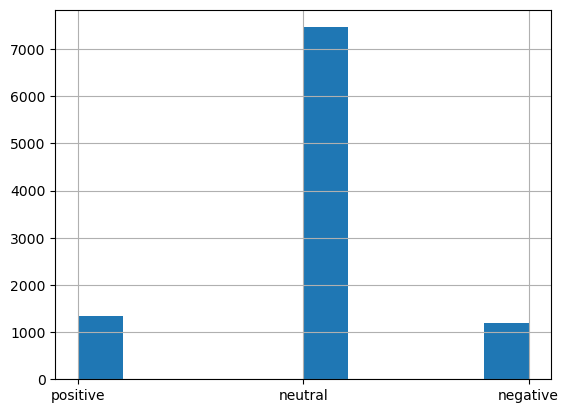

In [57]:
# Выведем график тональности заголовков новостей
df_title_news_concat['sentiment_label'].hist()

In [58]:
# Статистика тональности заголоаков новостей
df_title_news_concat.groupby(['sentiment_label']).agg({'sentiment_label': ['count']})

,sentiment_label
,count
sentiment_label,
negative,1186
neutral,7463
positive,1351


## Обучение модели

In [59]:
le = LabelEncoder()
# Преобразуем в датафрейме буквеное обозначение в цифровое
df_title_news_concat['sentiment_label'] = le.fit_transform(df_title_news_concat['sentiment_label'].astype(str))

In [60]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,2
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",1
2,Из Чернокозово отпущены первые амнистированные...,0
3,Парламент Украины затребовал у Конгресса США п...,1
4,Пилот Формулы-1 уцелел в авиакатастрофе,2


In [61]:
# Перемешивание данных
df_title_news_concat = shuffle(df_title_news_concat)

In [62]:
# Разделение датасета на размеченную и неразмеченную выборки
labeled_title, unlabeled_title = train_test_split(df_title_news_concat, train_size=0.2, random_state=42)

In [63]:
labeled_title.head()

,title,sentiment_label
9849,Украинские коммунисты устроили драку в Верховн...,1
8315,Налоговая полиция проверит Московское отделени...,1
3971,Большой театр эвакуировался напрасно,2
6158,Боевики напали на автоколонну Ханты-Мансийског...,1
4025,Контрразведчики по-прежнему считают Пасько шпи...,1


In [64]:
unlabeled_title.head()

,title,sentiment_label
2521,Ряды жириновцев редеют на глазах,1
7577,Радуев: журналисты нанесли вред моему политиче...,0
8235,Пенсионный возраст для мужчин и женщин подниму...,1
8115,Федералы опровергают информацию о гибели в Чеч...,1
672,Землетрясение в Турции: 70 человек пострадали,0


In [65]:
# Определение функции для обучения модели логистической регрессии на размеченных данных
def train_model(labeled_title):
    # Векторизация текстовых данных с помощью TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_title['title'])
    y = labeled_title['sentiment_label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

In [66]:
# Обучение начальной модели на небольшом наборе 
model, vectorizer = train_model(labeled_title)

In [67]:
# Использование исходной модели для прогнозирования настроения неразмеченных данных
X_unlabeled = vectorizer.transform(unlabeled_title['title'])
y_unlabeled_predicted = model.predict(X_unlabeled)

In [68]:
# Вычислить неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [69]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[:100]]
unlabeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[100:]]

In [70]:
labeled_title_new

,title,sentiment_label
8825,В Чечне началась спецоперация по уничтожению л...,1
990,Дело Козленка передано в суд,1
7180,Из СИЗО в Чернокозово по амнистии отпустят еще...,1
4531,Палестинские экстремисты поддерживают чеченски...,0
9194,В горах уничтожена группа чеченских боевиков,1
...,...,...
8264,Путин заявил об освобождении российских летчиков,1
2254,Безопасность российских граждан в Грузии под у...,2
5401,Путин: Организованное сопротивление в Чечне сл...,0
6684,Московские рэкетиры финансировали чеченских бо...,1


In [71]:
# Разметка новых точек данных и добавление их к размеченному множеству
labeled_title = pd.concat([labeled_title, labeled_title_new])

In [72]:
labeled_title.shape

(2100, 2)

In [73]:
unlabeled_title_new.shape

(7900, 2)

In [74]:
# Переобучение модели на расширенном маркированном множестве
model, vectorizer = train_model(labeled_title)

## Оценка обучения модели

In [76]:
### Загружаем тестовый датасет
title_test = pd.read_csv('test.csv', engine='python', on_bad_lines='skip')

In [77]:
# Преобразуем в датафрейме буквеное обозначение в цифровое
title_test['sentiment_label'] = le.fit_transform(title_test['sentiment_label'].astype(str))

In [78]:
title_test.head()

,title,sentiment_label
0,Вагоны московского метро будут складываться га...,1
1,В Чечню пытались проникнуть наемники из Пакистана,1
2,Таллинские заключенные предпочитают голод духоте,0
3,"Адвокатам ""Моста"" не удалось дать отвод следов...",1
4,В поезде Донецк-Москва нашли взрывчатку,1


In [79]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(title_test['title'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(title_test['sentiment_label'], y_test_predicted, average='micro')

print(f1)

0.83968


## Вывод:

### Выполнена разметка выбранного подмножества на основе правил, произведена разметка вручную другого подмножества. Объединены эти две выборки в один дасет и произведено обучение модели. Эффективность обученной модели составила 84%. Разметка на основе правил существенно экономит трудозатраты.